In [1]:
#MODULE NAME
import os
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.exposure as exposure
import pandas as pd
import numpy as np
import subprocess
import snappy
import imageio
import rasterio as rio
import rasterstats as rs
import rasterio.plot 
from glob import iglob
import geopandas as gpd
from pyspatialml import Raster
import seaborn as sns
from rasterio.plot import show
get_ipython().run_line_magic('matplotlib', 'inline')
from osgeo import gdal
import prosail
from prosail import spectral_lib
import numpy as np
import numpy.matlib
import numpy as np
from numpy.random import seed
from numpy.random import rand
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd

In [24]:
#Installing packages

#Needed for step 1 - data generation

#Installing PROSAIL
#!pip install prosail

#latin hypercube stuff
#lets try to do a LHS
#!pip install lhsmdu

#this package as a number of functions to deal with hyperspectral data
#!pip install pysptools

#General purpose: 
import matplotlib.pyplot as plt
import numpy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

#PROSPECT+SAIL Radiative transfer mode package
import prosail

#Sampling design package
import lhsmdu

#package to for operations on spectral data
import pysptools as sptool 
from pysptools import distance
#machine learning packages are imported later, nearer to the model
from numpy.random import seed
from numpy.random import rand
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd

# Sentinel 2 data

In [6]:
with rasterio.open(r'C:\Users\BSibiya\Desktop\study_area\sentinel-Image\study_area.tif') as src:
    Aerosols = src.read(1, masked=True) #B1
    blue = src.read(2, masked=True) #B2
    green = src.read(3, masked=True) #B3
    red = src.read(4, masked=True) #B4
    Red_Edge_1 = src.read(5, masked=True) #B5
    Red_Edge_2 = src.read(6, masked=True) #B6
    Red_Edge_3 = src.read(7, masked=True) #B7
    nir = src.read(8, masked=True) #B8
    Red_Edge_4 = src.read(9, masked=True) #B8A
    Water_vapor = src.read(10, masked=True) #B9
    swir_1 = src.read(11, masked=True) #B11
    swir_2 = src.read(12, masked=True) #B12
    
np.seterr(divide='ignore', invalid='ignore')
VI_output = '/Users/BSibiya/Desktop/study_area/VI-output/'


### Visualize Image

In [16]:
src=rasterio.open(r'C:\Users\BSibiya\Desktop\study_area\sentinel-Image\study_area.tif',mode='r+')
srcg=gdal.Open(r'C:\Users\BSibiya\Desktop\study_area\sentinel-Image\study_area.tif')
ysm=np.shape(src.read(1))[0]
xsm=np.shape(src.read(1))[1]

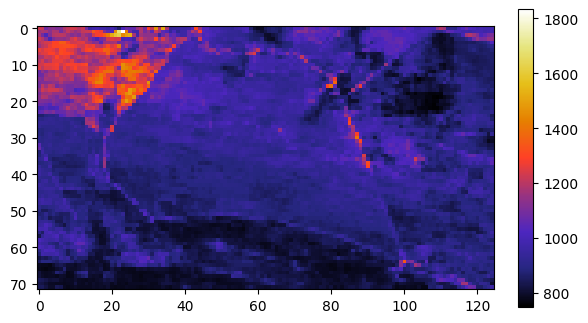

In [17]:
plt.imshow(blue, cmap='CMRmap')
plt.colorbar(fraction=0.03)
plt.savefig("colbr.png")

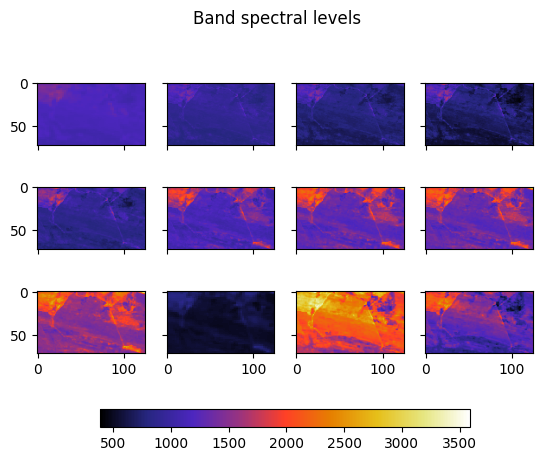

In [18]:
from matplotlib import colors

Nr = 3
Nc = 4
cmap = "CMRmap"

fig, axs = plt.subplots(Nr, Nc)
fig.suptitle('Band spectral levels')
inx=1
images = []
for i in range(Nr):
    for j in range(Nc):
        # Generate data with a range that varies from one plot to the next.
        images.append(axs[i, j].imshow(src.read(inx), cmap=cmap))
        axs[i, j].label_outer()
        inx=inx+1

# Find the min and max of all colors for use in setting the color scale.
vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in images:
    im.set_norm(norm)

fig.colorbar(images[0], ax=axs, orientation='horizontal', fraction=0.05)

plt.show()

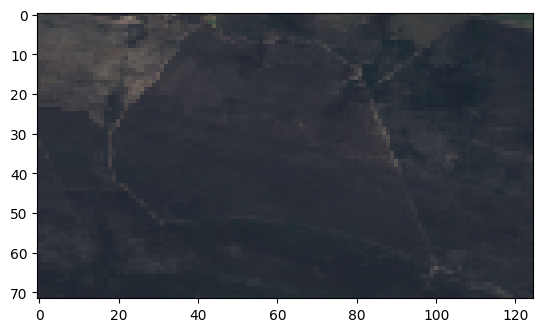

In [19]:
block2=np.zeros((ysm,xsm,12))
for j in range(1,13):
    block2[:,:,j-1]=np.minimum(src.read(j)/4096,1)
    
plt.imshow(block2[:,:,(3,2,1)])

### Function to calculate vegetation indices

In [21]:
#Function to calculate vegetation indices from band combinations
#Raster_output_name - name of the vegetation index which will be saved 
#VI_name - name of the vegetation index
#cmap_output_name - name of the png file where the file will be stored with colormap applied
#plot_title - title of the image produced 

def create_vegetation_indices(raster_output_name, VI_name, cmap_output_name, plot_title):
    np.seterr(divide='ignore', invalid='ignore')
    kwargs = src.meta
    kwargs.update(
        dtype=rasterio.float32,
        count = 1)
    
    with rasterio.open(VI_output + raster_output_name, 'w', **kwargs) as dst:
        dst.write_band(1, VI_name.astype(rasterio.float32))
    
    plt.imsave(VI_output + cmap_output_name, VI_name, cmap=plt.cm.RdYlGn)
    plt.imshow(VI_name, cmap=cm.RdYlGn)
    plt.colorbar()
    plt.title(plot_title)
    plt.show()
    
#Normalizes numpy arrays into scale -1.0 - 1.0
#array - indicates in this case the array of the image to normalize
def normalize(array):
    array_min, array_max = array.min(-1), array.max(1)
    return ((array - array_min)/(array_max - array_min))

#### Normalized Difference Moisture Index - NDMI

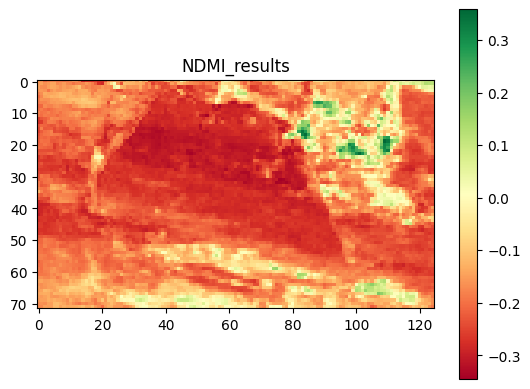

In [23]:
#Equation to calculate NDMI
ndmi = (nir.astype(float) - swir_1.astype(float)) / (nir + swir_1)
#create NDMI bands with the use of create_vegetation_indices function from section 3 - user defined functions 
#The result will be written into tiff and png file with the colormap applied
#ndmi_results = create_vegetation_indices('1_NDMI.tif', ndmi, '1_NDMI_cmap.png', 'NDMI_results') 

# Simulated data using PROSAIL

### The parameters used by the models 

In [38]:
krange = 1000 #samples
n = 1.28 #number of observation 
cab = rand(krange)*80 #Chlorophyll a+b concentration (ug/cm2)
car = rand(krange)*10 # carotenoid content of the canopy (in SPAD)
cbrown = 0 #Brown pigment content of the canopy (in g/cm^2)
cw = rand(krange)*200 # Equivalent water thickness of the canopy (in cm)
cm = rand(krange)*200  # Dry matter content of the canopy (in g/cm^2)
lai = rand(krange)*10 #Leaf Area Index

lidfa = 45 # leaf angle distribution parameter (in degrees)
hspot = 0.1 # Hotspot parameter (in cm)
tts = 30 # solar zenith angle (in degrees)
tto = 10 # sensor zenith angle (in degrees)
psi = 0 # Azimuth angle - difference between sun and sensor (in degrees)
ant = 0 #Antenna effect (in percent)
alpha = 40.0 # weighting factor for the PRI (photochemical reflectance index)
prospect_version = '5' #prospect version
typelidf = 2 # leaf type index 
lidfb = 0.0 #leaf angle distribution parameter for background (in degrees)
factor = 'DHR' # soil factor 
rsoil0 = None # initial value for the soil reflectance
rsoil = 1 # soil reflectance (Soil brigthness factor) soil reflectance at the red edge position 
psoil = 1 #soil reflectance at the red edge position (Dry/Wet soil factor)
soil_spectrum1 = None # first soil spectrum
soil_spectrum2 = None #second soil spectrum 

In [2]:
import numpy as np
from numpy.random import seed
from numpy.random import rand
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
krange=1000
N=1.28
chloro=rand(krange)*80
caroten=rand(krange)*8
brown=0
EWT=0.0005+rand(krange)*0.0695
LMA=0.003+rand(krange)*0.005
LAI=rand(krange)*8
hot_spot=0.2+rand(krange)*0.3
solar_zenith=numpy.matlib.repmat(np.arange(25,75,10),2,1).T.flatten()
solar_azimuth=numpy.matlib.repmat(np.arange(150,170,10),1,5).flatten()
view_zenith=0
view_azimuth=0
LIDF=2*rand(krange,2)-1
skyl=0.2
#soilType=pyPro4SAIL.DEFAULT_SOIL
sal=len(solar_zenith)
rho=np.zeros((sal,krange,2101))

In [11]:
len(solar_zenith)

10

In [10]:
import prosail

In [15]:
n = 1.5 #Leaf structure parameter
chloro = [cab for cab in np.arange(0, 80+1)] #Chlorophyll a+b concentration
caroten = [car for car in np.arange(0, 20+1)] #Carotenoid concentration
brown = 0.0 #Brown pigment
EWT = [cw for cw in np.arange(0, 200+1)] #Equivalent water thickiness
LMA = [cm for cm in np.arange(0, 200+1)] #Dry matter content
LAI = [lai for lai in np.arange(0, 10+1)] #Leaf Area Index
lidfa = -0.35 #Leaf angle distribution
hspot = 0.01 #Hotspot parameter
tts = 30.0 #Solar zenith angle
tto = 10.0 #Observer zenith angle
psi = 0.0 
typelidf=1 #Leaf angle distribution type
lidfb=-0.15 #Leaf angle distribution
rsoil=1.0 #Soil brigthness factor
psoil=1.0 #Dry/Wet soil factor
factor="SDR"

In [ ]:
krange=1000
n=1.28
chloro=rand(krange)*80
caroten=rand(krange)*8
brown=0
EWT=0.0005+rand(krange)*0.0695
LMA=0.003+rand(krange)*0.005
LAI=rand(krange)*8
hot_spot=0.2+rand(krange)*0.3
solar_zenith=numpy.matlib.repmat(np.arange(25,75,10),2,1).T.flatten()
solar_azimuth=numpy.matlib.repmat(np.arange(150,170,10),1,5).flatten()
view_zenith=0
view_azimuth=0
LIDF=2*rand(krange,2)-1
skyl=0.2
soilType=pyPro4SAIL.DEFAULT_SOIL
sal=len(solar_zenith)
rho=np.zeros((sal,krange,2101))

In [ ]:
rho_canopy = prosail.run_prosail(n, np.arange(0, 80+1), car, cbrown, cw, cm, lai, lidfa, hspot, tts, tto, psi, \
                    ant=0.0, alpha=40.0, prospect_version='5', typelidf=2, lidfb=0.0, \
                    factor='SDR', rsoil0=None, rsoil=None, psoil=None, \
                    soil_spectrum1=None, soil_spectrum2=None)